### Simple 1D example of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    periodic_step,
)
from dataset import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNet,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Initialize

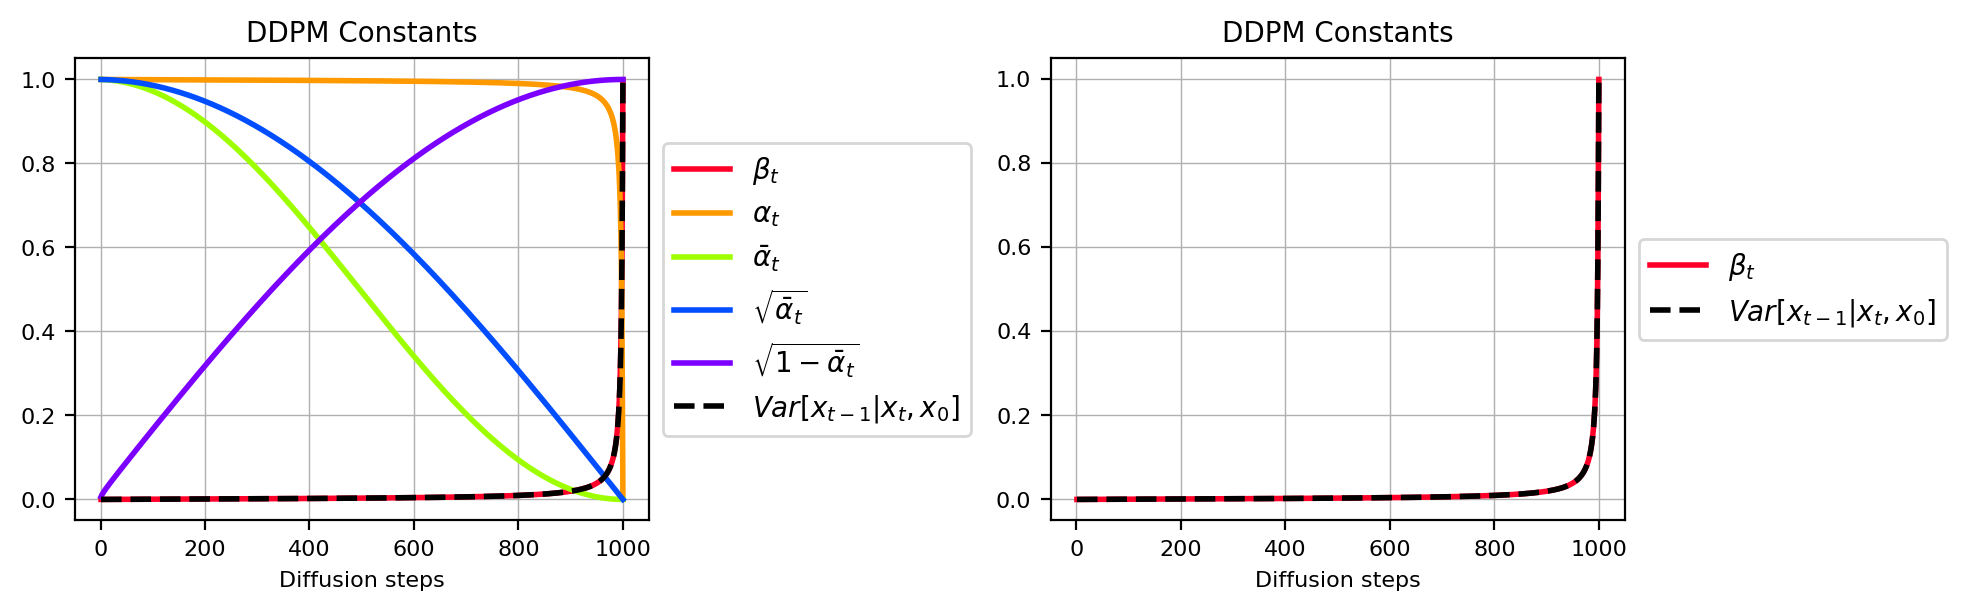

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# for k_idx,key in enumerate(dc.keys()): print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

In [3]:
# Instantiate U-net
device = 'mps' # mps, cpu
model = DiffusionUNet(
    name             = 'unet',
    dims             = 1,
    n_in_channels    = 1,
    n_model_channels = 32,
    n_emb_dim        = 128,
    n_enc_blocks     = 4, # number of encoder blocks
    n_dec_blocks     = 4, # number of decoder blocks
    n_groups         = 16, # group norm paramter
    kernel_size      = 15, # kernel size (3)
    padding          = 7, # padding size (1)
    skip_connection  = True, # additional skip connection
    device           = device,
) # input:[B x C x L] => output:[B x C x L]
print ("Ready.")

Ready.


### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

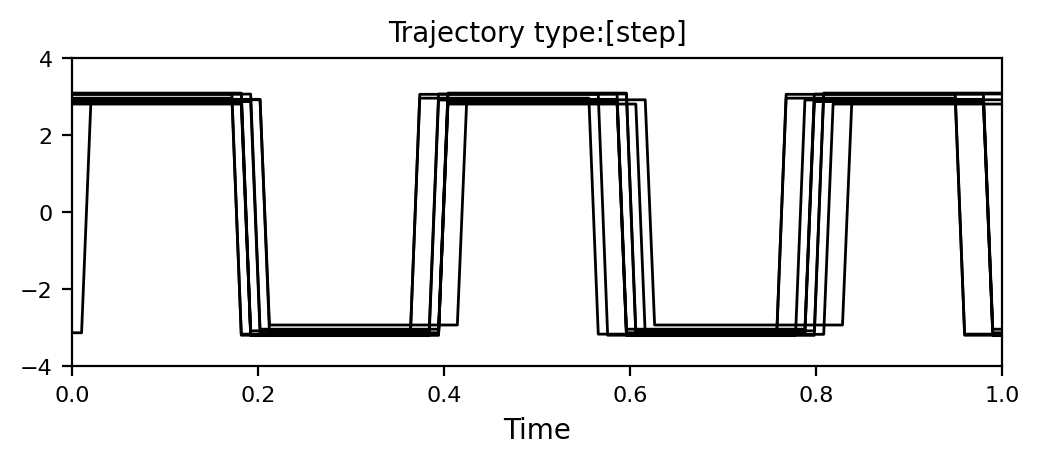

x_0:[10x1x100]


In [4]:
times,x_0 = get_1d_training_data(
    traj_type = 'step', # step / gp
    n_traj    = 10,
    L         = 100,
    device    = device,
    seed      = 1,
    plot_data = True,
    verbose   = True
    )

### Train

it:[      0][0.0]% loss:[3.5319]


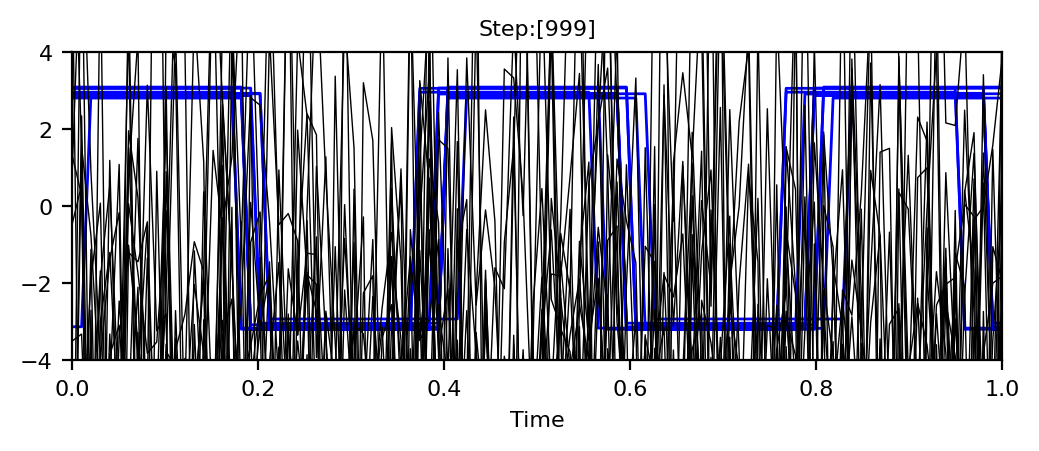

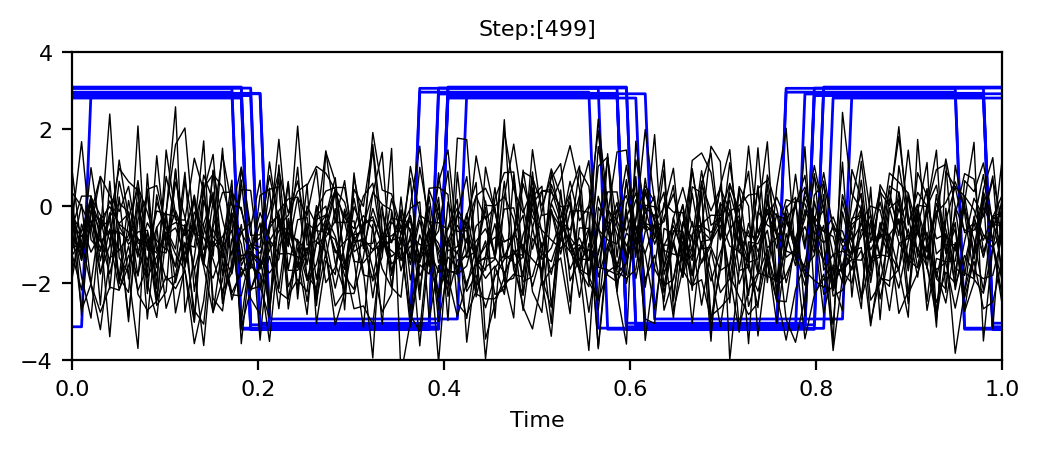

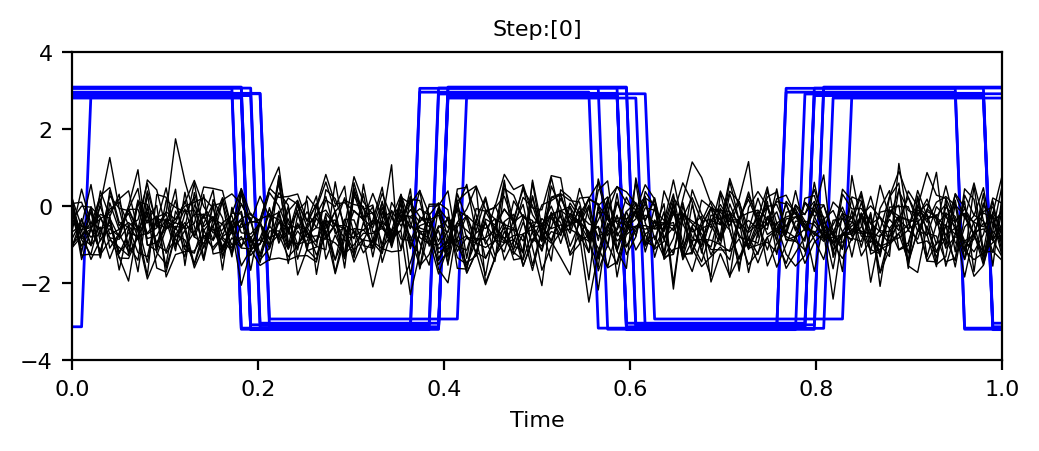

it:[   1000][10.0]% loss:[0.0488]


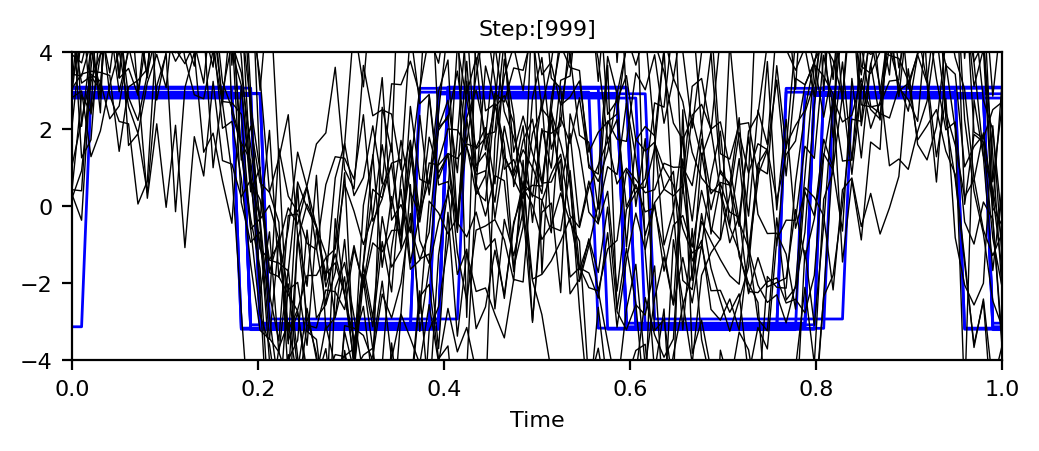

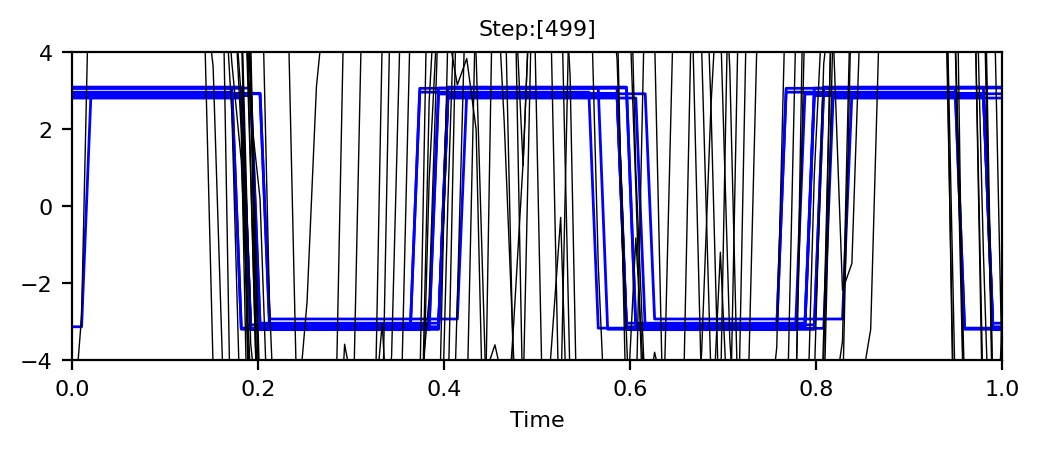

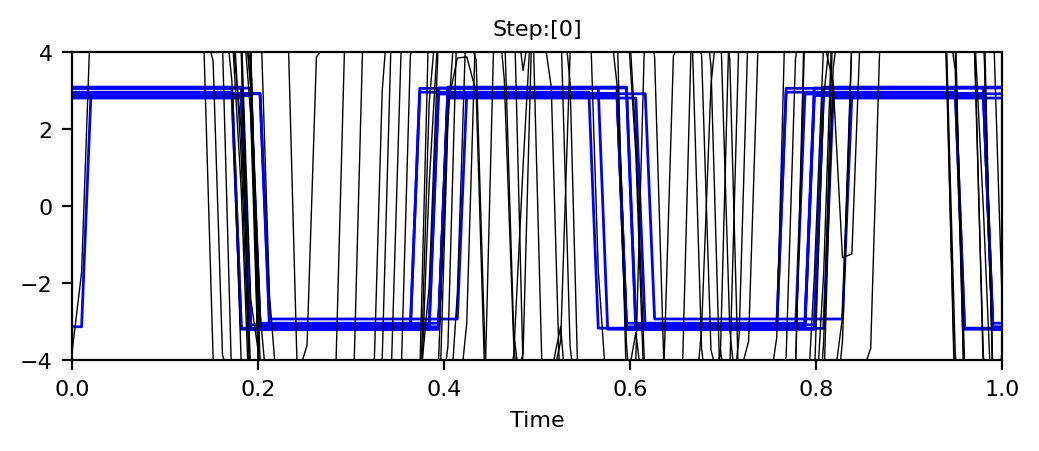

it:[   2000][20.0]% loss:[0.0266]


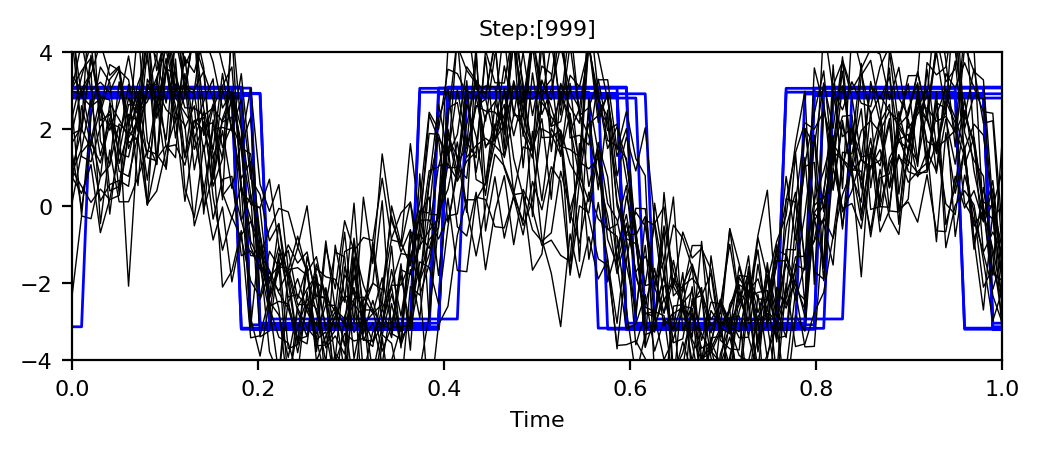

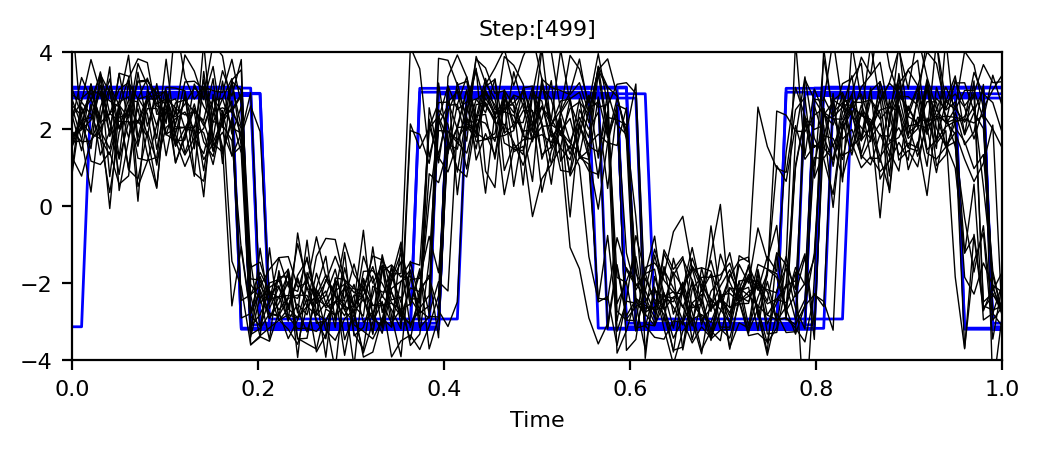

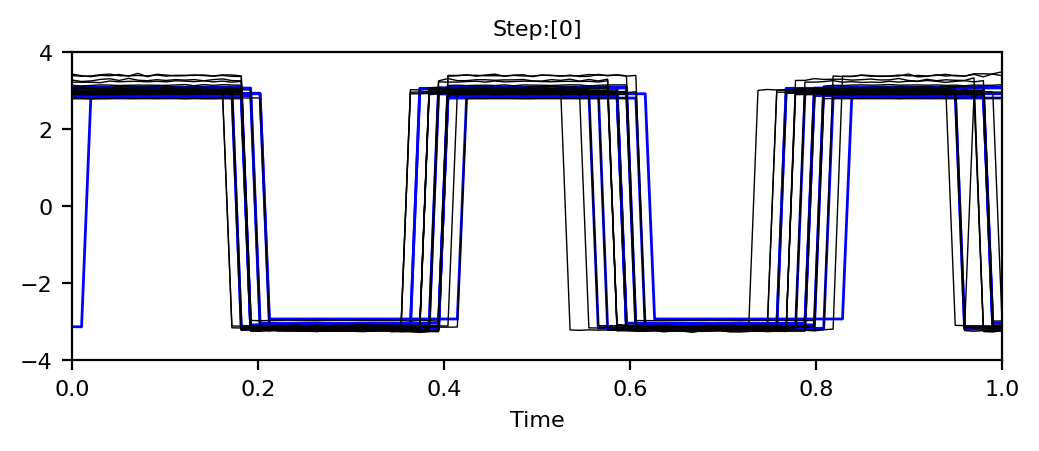

it:[   3000][30.0]% loss:[0.0208]


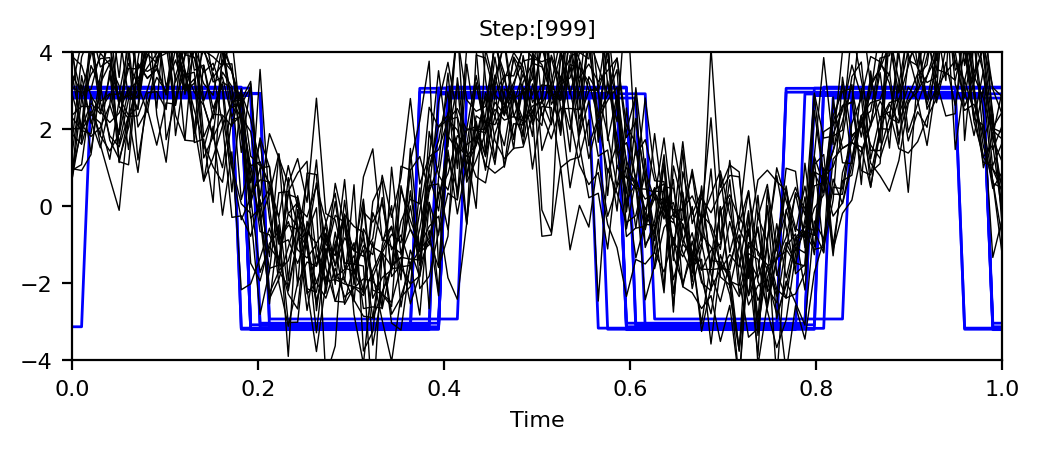

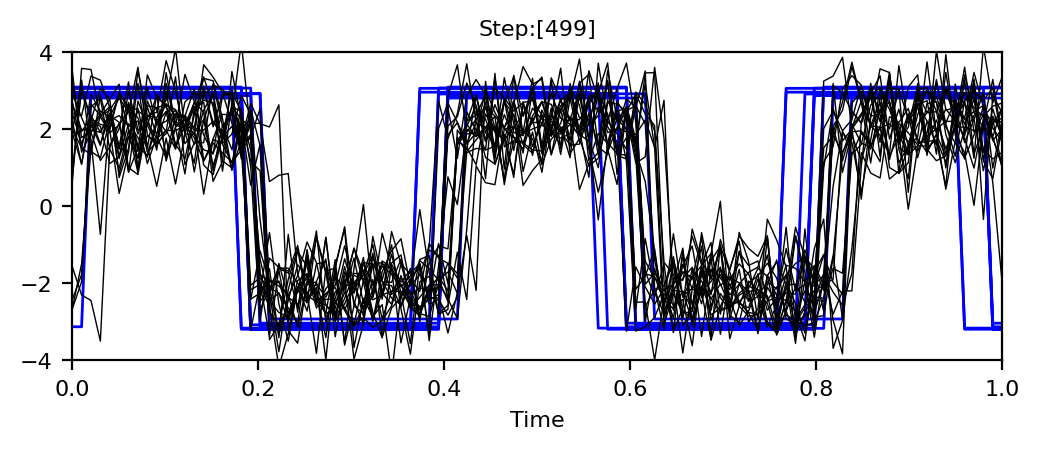

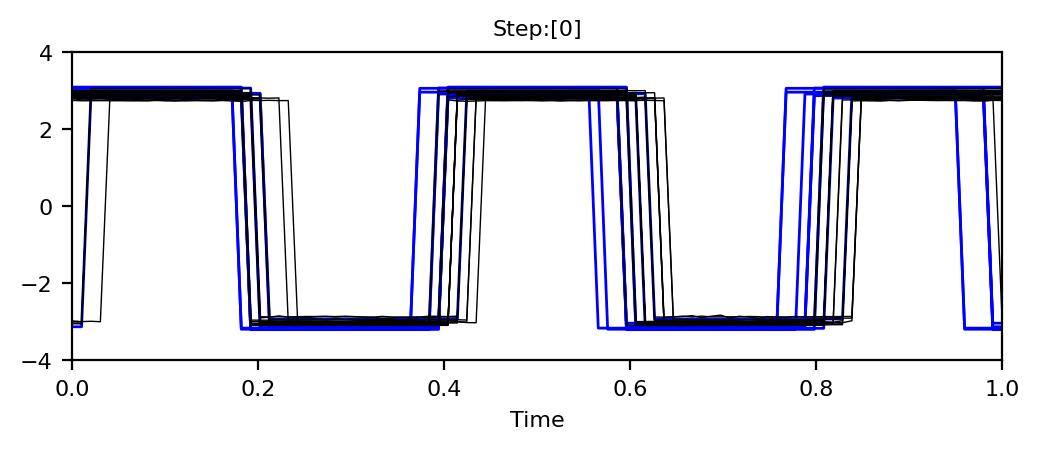

it:[   4000][40.0]% loss:[0.0193]


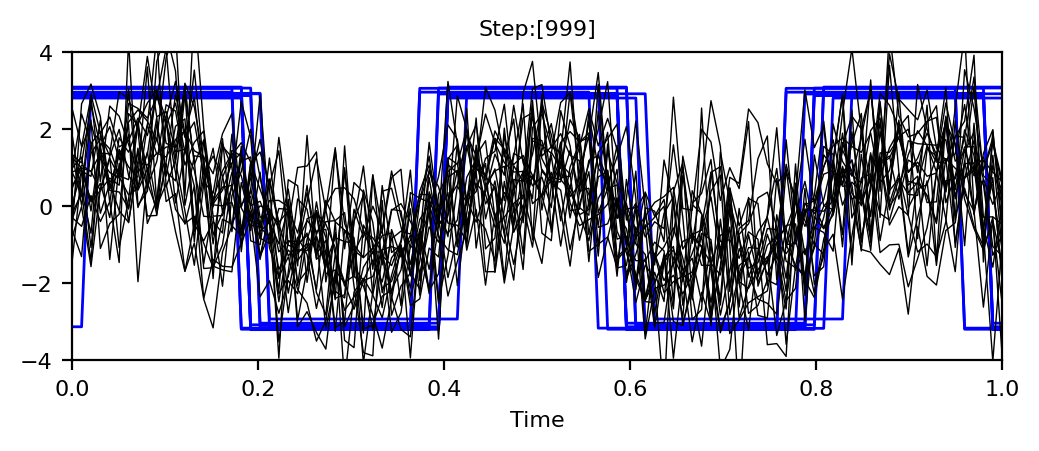

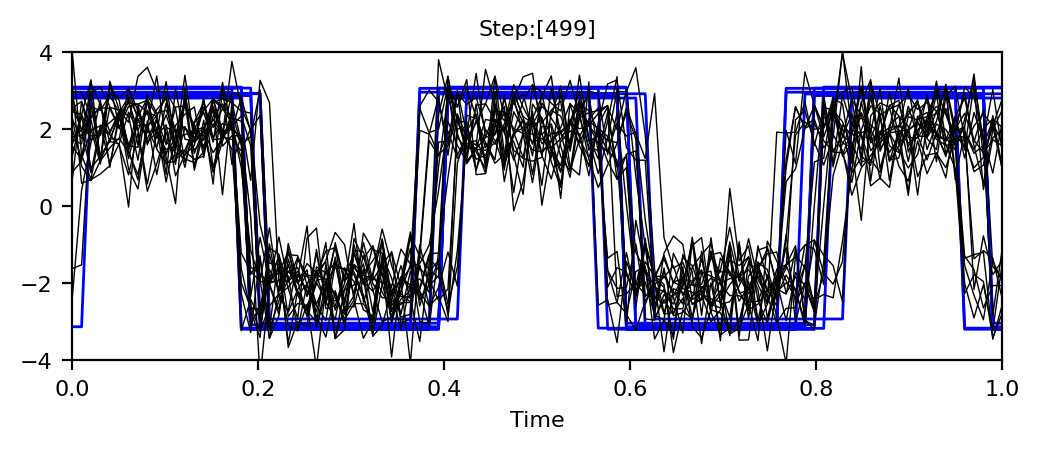

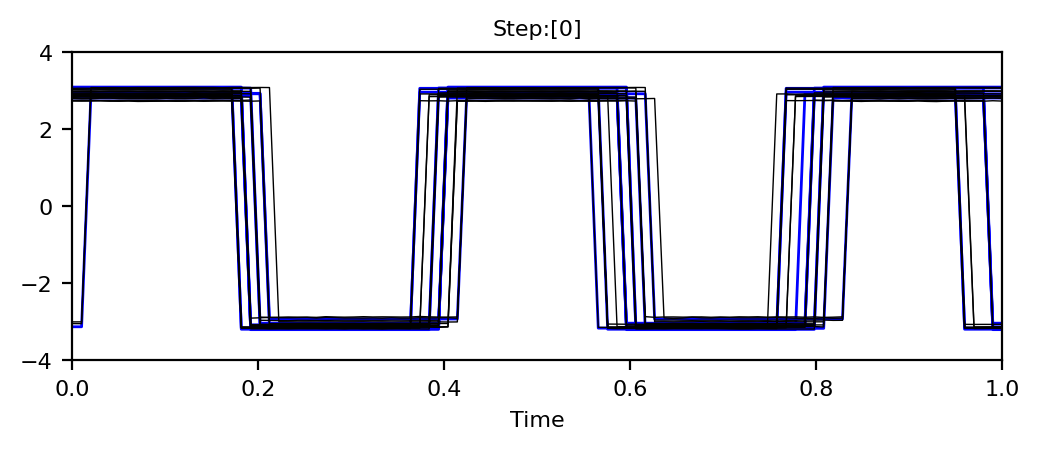

it:[   5000][50.0]% loss:[0.0174]


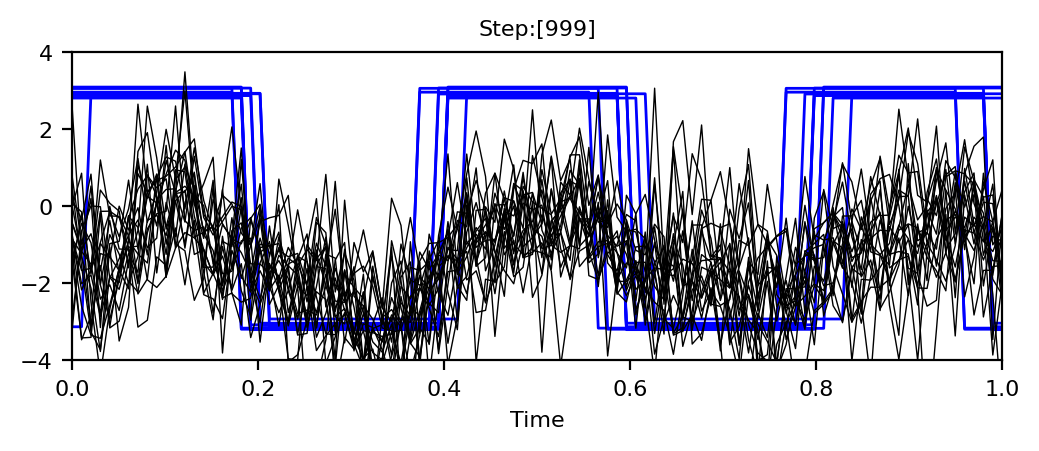

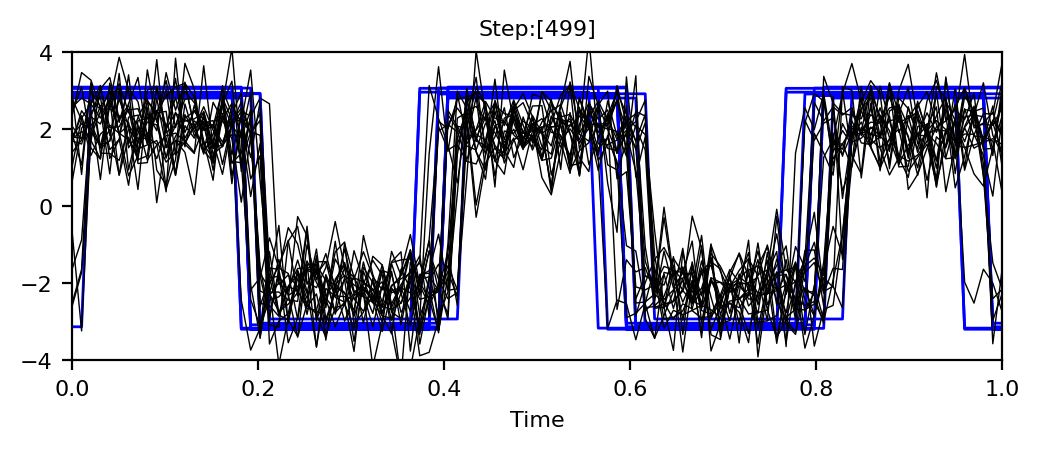

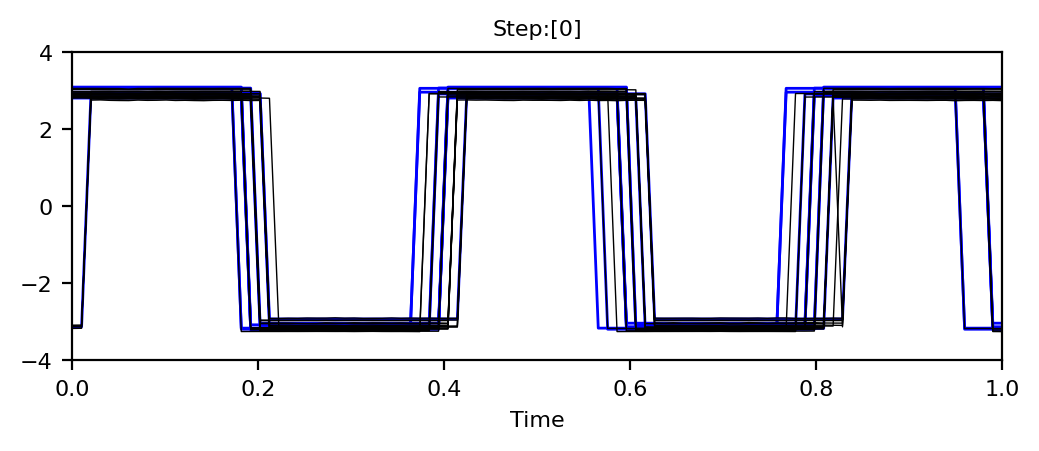

it:[   6000][60.0]% loss:[0.0180]


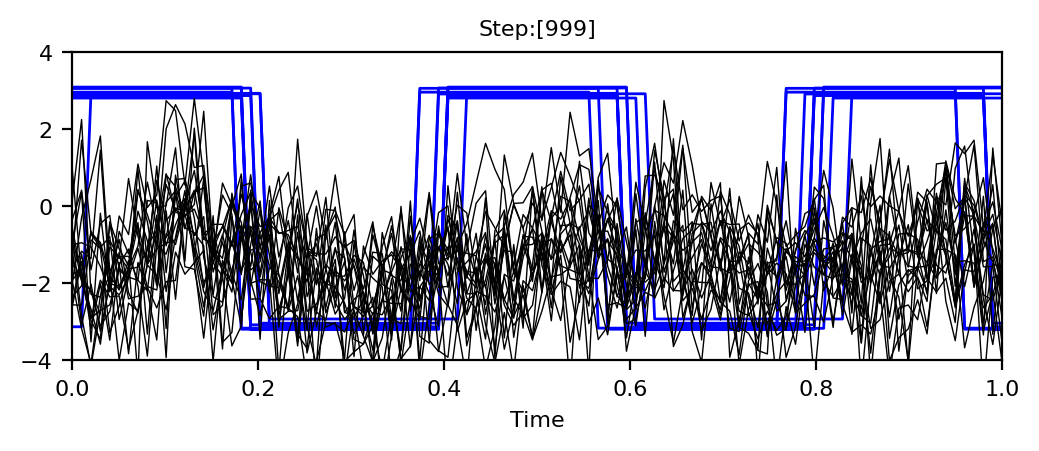

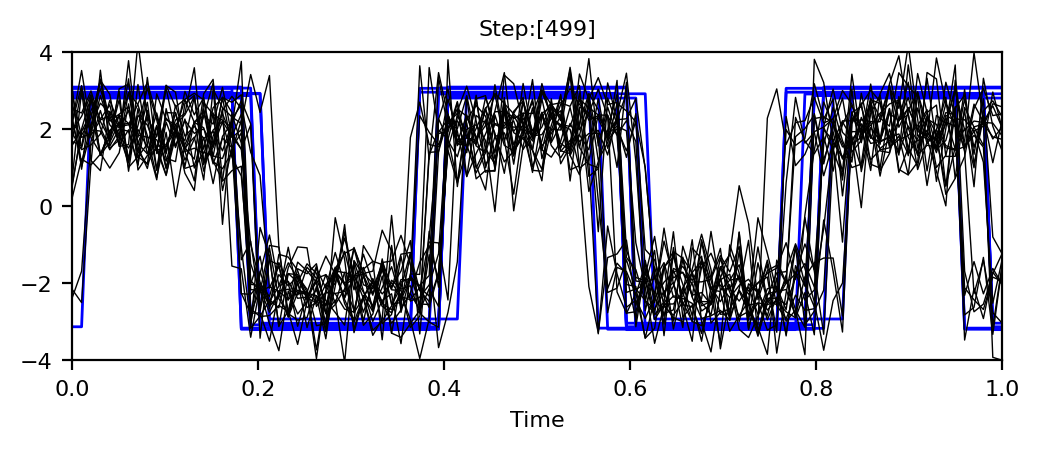

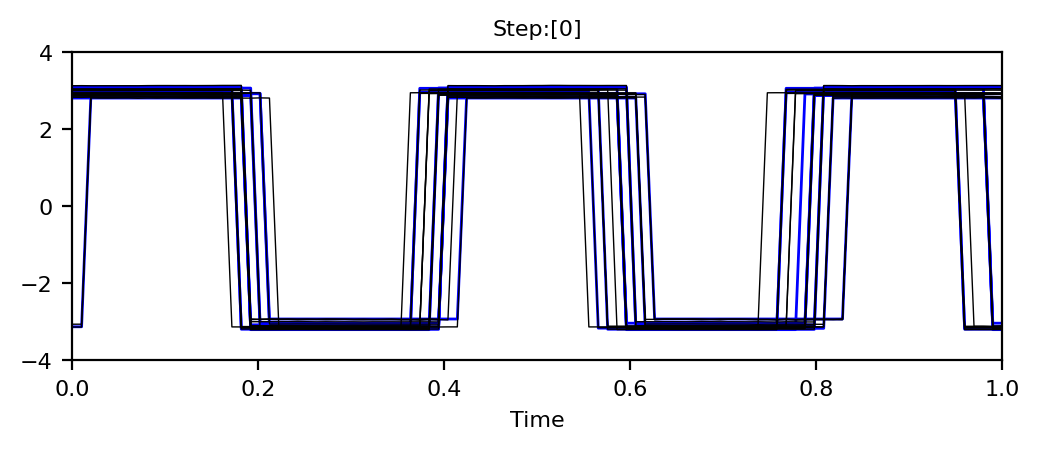

it:[   7000][70.0]% loss:[0.0096]


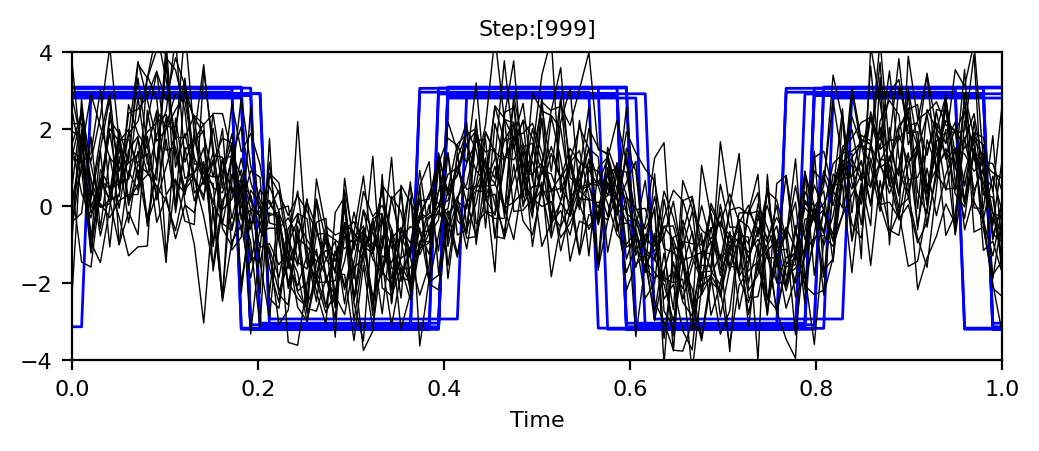

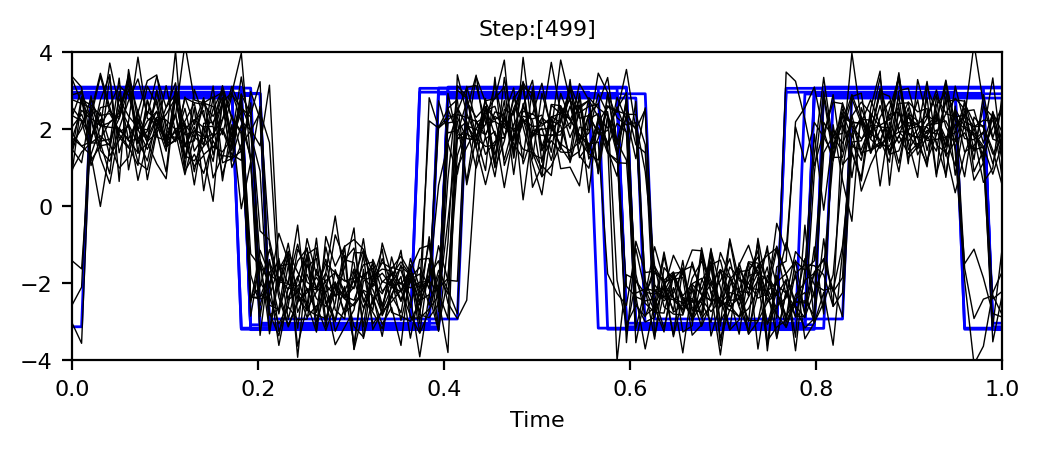

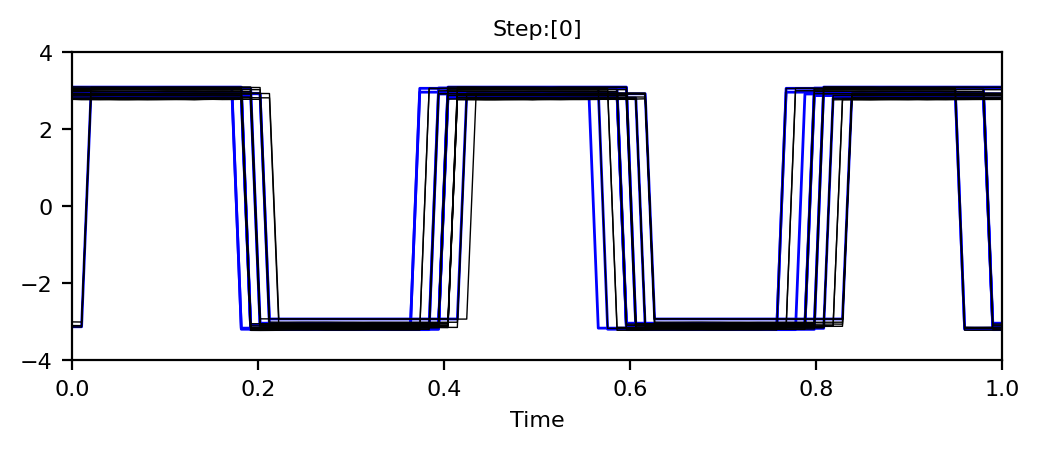

it:[   8000][80.0]% loss:[0.0119]


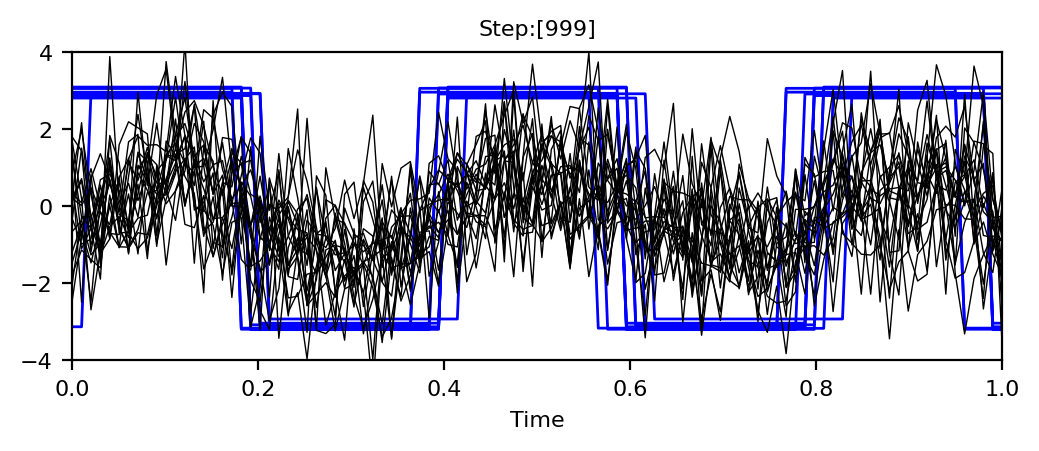

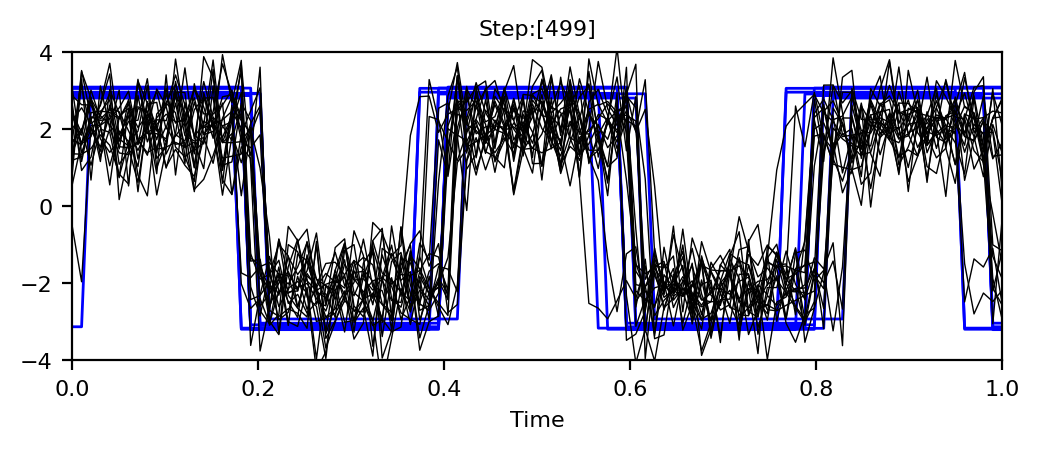

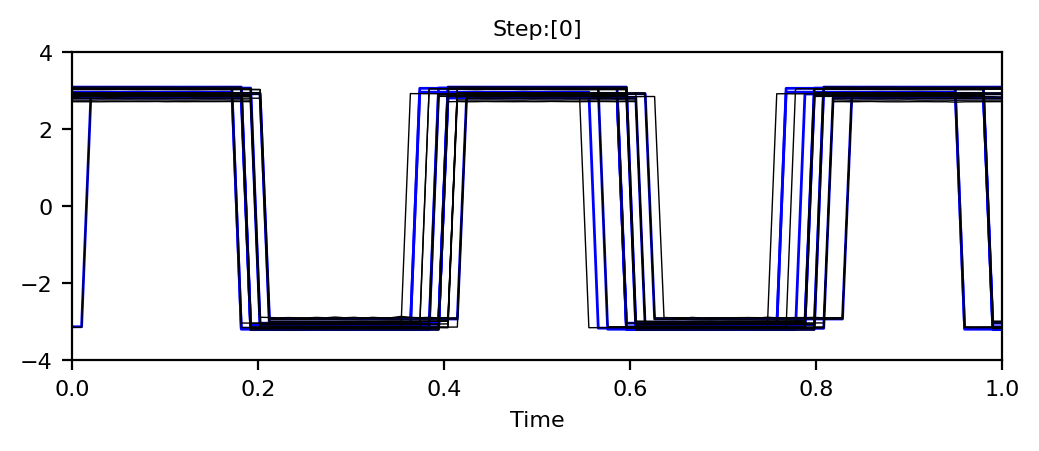

it:[   9000][90.0]% loss:[0.0076]


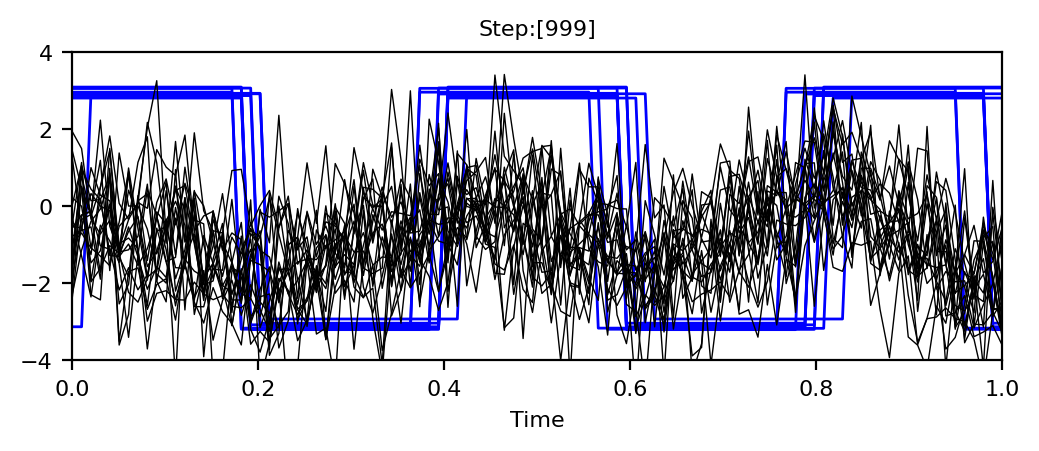

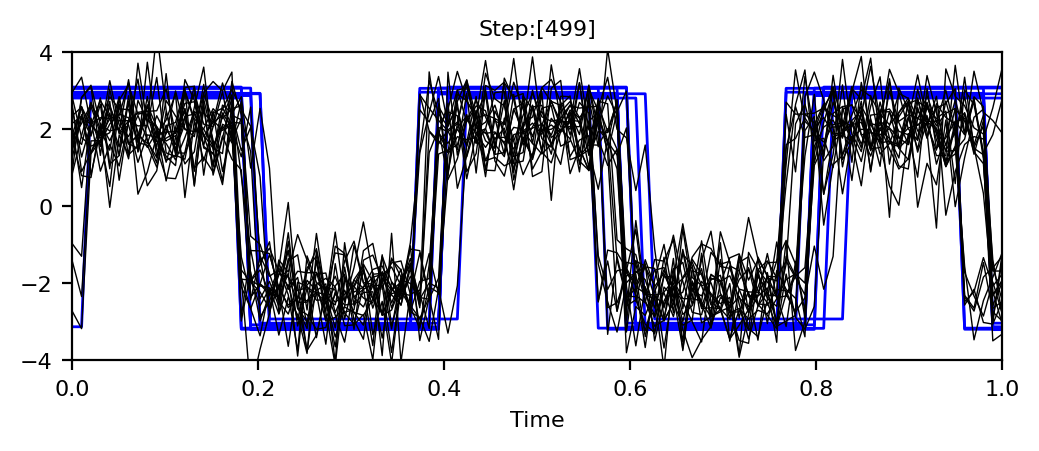

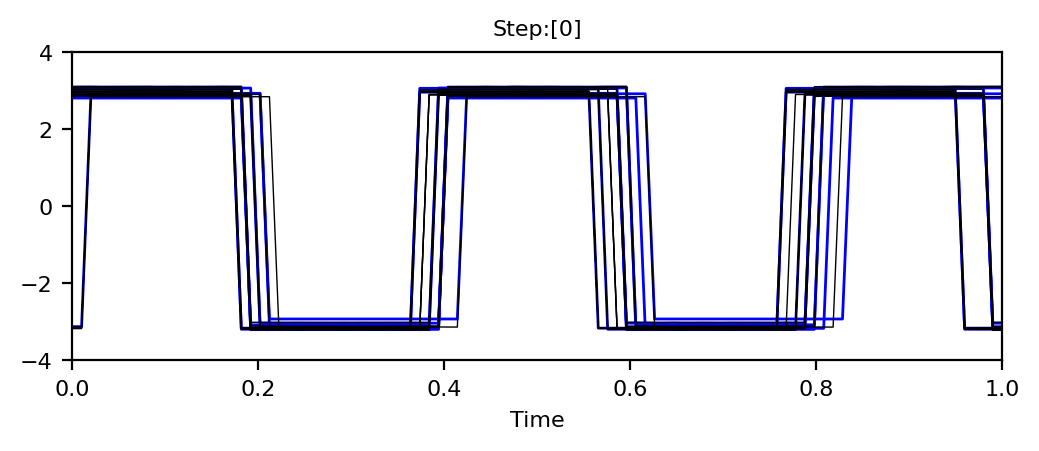

it:[   9999][100.0]% loss:[0.0077]


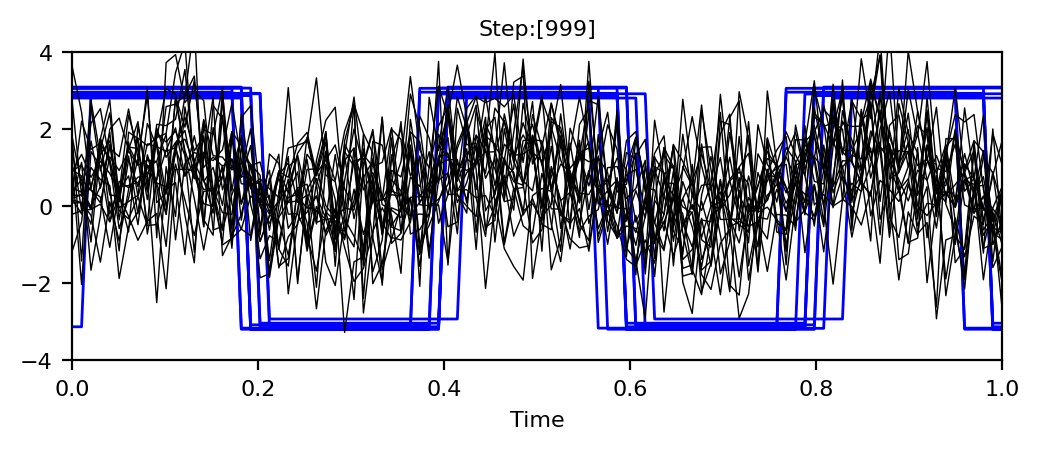

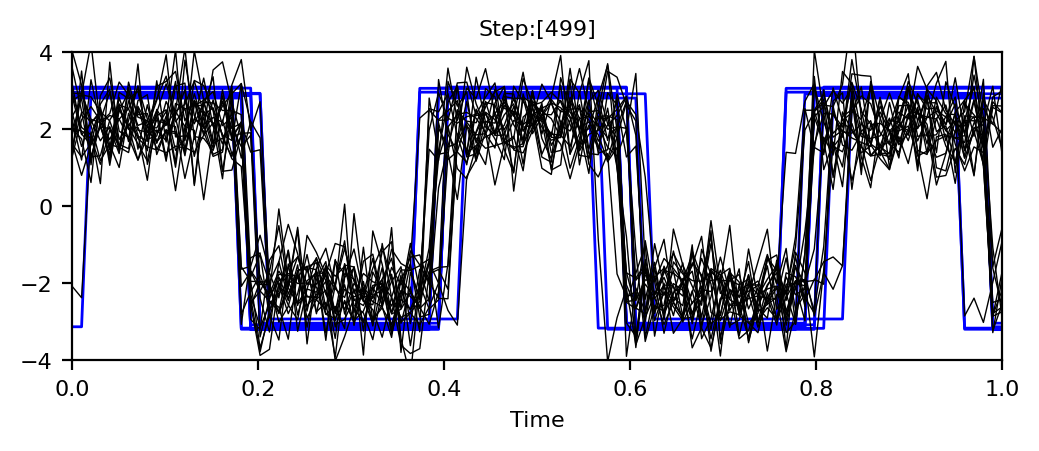

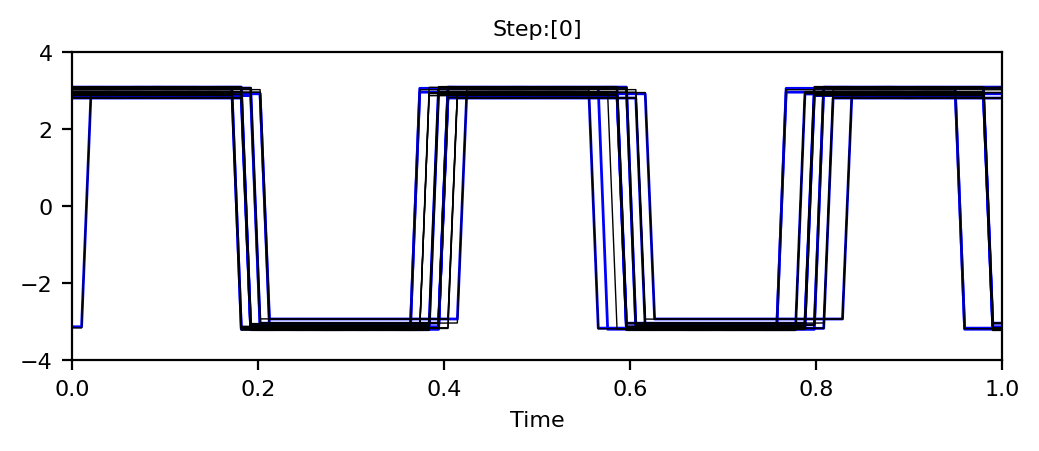

Done.


In [5]:
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 1e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x L]

    # Model predict
    noise_pred,_ = model(x_t_batch,step_batch) # [B x C x L]
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        eval_ddpm_1d(model,dc,n_sample,times,x_0,device,ylim=(-4,+4))

print ("Done.")